# Colab Setup for Probe Research

**Purpose:** Set up Google Colab environment with GPU for mechanistic interpretability work.

**Steps:**
1. Enable GPU in Colab
2. Install required packages
3. Verify GPU access
4. Test transformer_lens with GPU

---

## ⚠️ FIRST: Enable GPU in Colab

**Before running any code:**
1. Click **Runtime** → **Change runtime type**
2. Set **Hardware accelerator** to **GPU** (T4 or better)
3. Click **Save**

Then proceed with the cells below.

---

## Step 1: Check GPU Availability

In [ ]:
import torch

print("=" * 50)
print("GPU Availability Check")
print("=" * 50)

if torch.cuda.is_available():
    print(f"✅ CUDA available: {torch.cuda.is_available()}")
    print(f"✅ CUDA version: {torch.version.cuda}")
    print(f"✅ GPU device: {torch.cuda.get_device_name(0)}")
    print(f"✅ GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"\n🚀 Ready for GPU-accelerated computations!")
else:
    print("❌ No GPU detected!")
    print("⚠️  Go to Runtime → Change runtime type → Set Hardware accelerator to GPU")
    print("Then restart this cell.")

---

## Step 2: Install Required Packages

**Note:** Colab has PyTorch pre-installed. We just need to install:
- transformer-lens (mechanistic interpretability)
- Additional dependencies

In [1]:
# Install transformer-lens and dependencies
!pip install transformer-lens -q

print("\n" + "=" * 50)
print("Package Installation Complete")
print("=" * 50)


Package Installation Complete


In [3]:
# Verify installations
import transformer_lens as tl
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

print("✅ All packages imported successfully!")
print(f"✅ NumPy: {np.__version__}")
print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ TransformerLens ready!")

✅ All packages imported successfully!
✅ NumPy: 1.26.4
✅ PyTorch: 2.9.0+cu126
✅ TransformerLens ready!


---

## Step 3: Test GPU with Transformer Model

**This will:**
1. Load GPT-2 small on GPU
2. Run inference
3. Measure speed vs. CPU

In [4]:
import time

print("Loading GPT-2 small...")
model = tl.HookedTransformer.from_pretrained("gpt2-small")

# Move model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()
    print(f"✅ Model loaded on GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️  Model on CPU (slower)")

print(f"\nModel specs: {model.cfg.n_layers} layers, {model.cfg.d_model} dimensions")

Loading GPT-2 small...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
✅ Model loaded on GPU: Tesla T4

Model specs: 12 layers, 768 dimensions


In [5]:
# Speed test
test_prompt = "The capital of France is"

print("Running speed test...\n")

# Warm-up run
_ = model.run_with_cache(test_prompt)

# Timed run
start = time.time()
logits, cache = model.run_with_cache(test_prompt)
end = time.time()

print(f"⏱️  Inference time: {(end - start) * 1000:.2f} ms")
print(f"\nTop predictions:")
top_tokens = logits[0, -1].topk(5)
for i in range(5):
    token_id = top_tokens.indices[i]
    token_str = model.tokenizer.decode(token_id)
    prob = torch.softmax(logits[0, -1], dim=-1)[token_id].item()
    print(f"  {i+1}. '{token_str}' (prob: {prob:.2%})")

print(f"\n✅ GPU inference working!")

Running speed test...

⏱️  Inference time: 36.85 ms

Top predictions:
  1. ' now' (prob: 4.75%)
  2. ' the' (prob: 3.74%)
  3. ' a' (prob: 3.55%)
  4. ' home' (prob: 3.09%)
  5. ' in' (prob: 2.70%)

✅ GPU inference working!


---

## Step 4: Test Activation Extraction on GPU

**This tests the core operation for probe research.**

In [6]:
def get_final_token_activation(model, sentence, layer=6):
    """
    Extract activation of final token at specified layer.
    Works on both CPU and GPU.
    """
    _, cache = model.run_with_cache(sentence)
    layer_acts = cache["resid_post", layer]
    final_act = layer_acts[0, -1, :].cpu().numpy()  # Move to CPU for numpy
    return final_act

# Test with multiple sentences
test_sentences = [
    "I love this movie!",
    "This is terrible.",
    "The weather is nice today.",
]

print("Extracting activations from layer 6...\n")

start = time.time()
activations = []
for sent in test_sentences:
    act = get_final_token_activation(model, sent, layer=6)
    activations.append(act)
    print(f"✅ '{sent[:30]}...' → activation shape: {act.shape}")

end = time.time()

activations = np.array(activations)
print(f"\n⏱️  Total time: {(end - start):.2f} seconds")
print(f"📊 Combined activations shape: {activations.shape}")
print(f"\n✅ Activation extraction working on GPU!")

Extracting activations from layer 6...

✅ 'I love this movie!...' → activation shape: (768,)
✅ 'This is terrible....' → activation shape: (768,)
✅ 'The weather is nice today....' → activation shape: (768,)

⏱️  Total time: 0.11 seconds
📊 Combined activations shape: (3, 768)

✅ Activation extraction working on GPU!


---

## Step 5: Quick Probe Test on GPU

**Let's verify the full pipeline works.**

In [7]:
# Small sentiment dataset
positive = ["I love this!", "Amazing work!", "Great job!", "Fantastic!", "Excellent!"]
negative = ["I hate this.", "Terrible work.", "Poor job.", "Awful.", "Disappointing."]

print("Extracting activations for probe test...")

# Extract activations
X_pos = np.array([get_final_token_activation(model, s, layer=6) for s in positive])
X_neg = np.array([get_final_token_activation(model, s, layer=6) for s in negative])

X = np.vstack([X_pos, X_neg])
y = np.array([1]*len(positive) + [0]*len(negative))

print(f"✅ Dataset: {X.shape[0]} examples, {X.shape[1]} features")

# Train probe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
probe = LogisticRegression(max_iter=1000)
probe.fit(X_train, y_train)

train_acc = probe.score(X_train, y_train)
test_acc = probe.score(X_test, y_test)

print(f"\n=== Probe Performance ===")
print(f"Train accuracy: {train_acc:.2%}")
print(f"Test accuracy:  {test_acc:.2%}")

print(f"\n🎉 Full pipeline working on GPU!")

Extracting activations for probe test...
✅ Dataset: 10 examples, 768 features

=== Probe Performance ===
Train accuracy: 100.00%
Test accuracy:  100.00%

🎉 Full pipeline working on GPU!


---

## GPU Memory Management Tips

**Important for longer experiments:**

In [8]:
# Check GPU memory usage
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated(0) / 1e9
    reserved = torch.cuda.memory_reserved(0) / 1e9
    total = torch.cuda.get_device_properties(0).total_memory / 1e9
    
    print("=" * 50)
    print("GPU Memory Usage")
    print("=" * 50)
    print(f"Allocated: {allocated:.2f} GB")
    print(f"Reserved:  {reserved:.2f} GB")
    print(f"Total:     {total:.2f} GB")
    print(f"Free:      {total - reserved:.2f} GB")
    
    # Clear cache if needed
    # torch.cuda.empty_cache()
    # print("\n✅ CUDA cache cleared")

GPU Memory Usage
Allocated: 0.87 GB
Reserved:  1.02 GB
Total:     15.83 GB
Free:      14.80 GB


---

## Next Steps

✅ **Setup complete!** You can now:

1. **Upload your probe notebooks** to Colab and run them with GPU
2. **Process larger datasets** faster
3. **Test multiple layers** simultaneously
4. **Run Week 4 experiments** with better performance

**To save your work:**
- File → Download → Download .ipynb
- Or: File → Save a copy in Drive (recommended)

**Colab tips:**
- Sessions last ~12 hours with activity
- Save frequently (Ctrl+S)
- Download important results
- Free tier: ~15-20 hours GPU/week

---

**Ready to start probe research with GPU acceleration!** 🚀

# **Exploration of the Sentiment Probe**

In [9]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Create dataset
positive_sentences = [
    "I love this movie!",
    "This is amazing and wonderful!",
    "Great job, fantastic work!",
    "I absolutely loved every minute of that film.",
    "This is the best coffee I've ever tasted.",
    "She was so kind and helpful throughout the process.",
    "What a beautiful day to be outside.",
    "I'm thrilled with how the project turned out.",
    "The team did an outstanding job on this.",
    "I can't wait to visit again next year.",
    "This restaurant exceeded all my expectations.",
    "He's such a talented and generous person.",
    "I feel incredibly grateful for this opportunity.",
    "The service here is always fantastic.",
    "That was the most fun I've had in ages.",
    "I'm so proud of what we accomplished together.",
    "This book changed my perspective completely.",
    "The sunset tonight was absolutely stunning.",
    "I've never felt more welcomed anywhere.",
    "Everything about this experience was delightful.",
    "She gave the most inspiring speech I've ever heard.",
    "I'm genuinely excited about what's next.",
    "This made my whole week better.",
]

negative_sentences = [
    "I hate this movie.",
    "This is terrible and awful.",
    "Poor job, disappointing work.",
    "I was deeply disappointed by the outcome.",
    "The food was cold and tasteless.",
    "This has been the worst customer service experience.",
    "I regret wasting my time on this.",
    "The whole event was a complete disaster.",
    "I'm frustrated with how poorly this was handled.",
    "Nothing about this met my expectations.",
    "The quality has really gone downhill.",
    "I felt completely ignored the entire time.",
    "This product broke after just one use.",
    "What a miserable waste of money.",
    "I've never been so let down by a company.",
    "The atmosphere was unpleasant and unwelcoming.",
    "I'm annoyed that nobody bothered to help.",
    "This ruined what should have been a good day.",
    "The wait was unbearable and unnecessary.",
    "I found the whole thing incredibly tedious.",
    "They clearly don't care about their customers.",
    "I'm upset that this turned out so badly.",
    "Everything that could go wrong did."
]

# Extract activations
def get_final_token_activation(model, sentences, layer=6):
    """Get activation of final token at specified layer"""
    activations = []
    for sentence in sentences:
        _, cache = model.run_with_cache(sentence)
        final_act = cache["resid_post", layer][0, -1, :].cpu().numpy()
        activations.append(final_act)
    return np.array(activations)

X_pos = get_final_token_activation(model, positive_sentences)
X_neg = get_final_token_activation(model, negative_sentences)

# Combine
X = np.vstack([X_pos, X_neg])
y = np.array([1]*len(positive_sentences) + [0]*len(negative_sentences))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train probe
probe = LogisticRegression(max_iter=1000, random_state=42)
probe.fit(X_train, y_train)

# Evaluate
train_acc = probe.score(X_train, y_train)
test_acc = probe.score(X_test, y_test)

print(f"Train accuracy: {train_acc:.2%}")
print(f"Test accuracy: {test_acc:.2%}")

Train accuracy: 100.00%
Test accuracy: 85.71%


## **Multi-Layer Comparison**

Layer 0: 85.71%
Layer 3: 85.71%
Layer 6: 85.71%
Layer 9: 92.86%
Layer 11: 92.86%


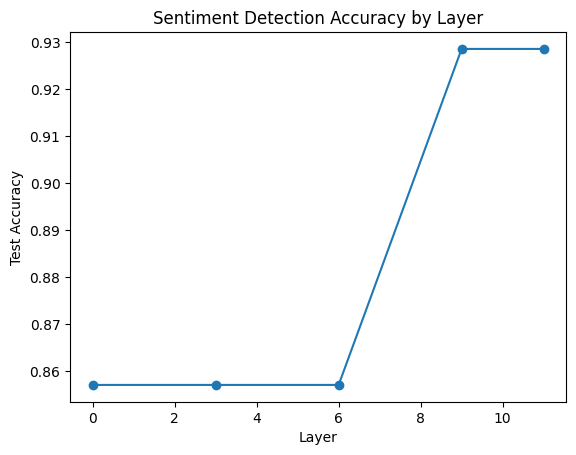

In [10]:
# Test which layer has best information
layers_to_test = [0, 3, 6, 9, 11]
results = []

for layer in layers_to_test:
    X_pos = get_final_token_activation(model, positive_sentences, layer=layer)
    X_neg = get_final_token_activation(model, negative_sentences, layer=layer)
    X = np.vstack([X_pos, X_neg])
    y = np.array([1]*len(positive_sentences) + [0]*len(negative_sentences))
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    probe = LogisticRegression(max_iter=1000)
    probe.fit(X_train, y_train)
    test_acc = probe.score(X_test, y_test)
    
    results.append((layer, test_acc))
    print(f"Layer {layer}: {test_acc:.2%}")

# Plot
import matplotlib.pyplot as plt
layers, accs = zip(*results)
plt.plot(layers, accs, marker='o')
plt.xlabel('Layer')
plt.ylabel('Test Accuracy')
plt.title('Sentiment Detection Accuracy by Layer')
plt.savefig('layer_comparison.png')

### **Generalization Testing**

**Test the sentiment probe on a new dataset**

---

In [12]:
# Test on very different distribution
different_positive = [
    "Moving to this city was the best decision I ever made.",
    "I'm amazed at how quickly they resolved my issue.",
    "The concert last night was absolutely incredible.",
    "I feel so lucky to have friends like these.",
    "This new phone works like a dream.",
    "Her painting genuinely moved me to tears.",
    "I've never seen a more well-organised event.",
    "The kids had the time of their lives at the party.",
    "This software has made my workflow so much easier.",
    "I woke up feeling refreshed and optimistic.",
    "The garden looks more beautiful than ever this spring.",
    "They went above and beyond to accommodate us.",
    "I'm impressed by how much progress we've made.",
    "That joke had everyone laughing for minutes.",
    "The hiking trail offered breathtaking views.",
    "I appreciate how thoughtful that gift was.",
    "This course has been genuinely transformative.",
    "The hotel room was spotless and comfortable.",
    "I've finally found a routine that works for me.",
    "Watching them succeed filled me with joy.",
]

different_negative = [
    "The flight delay ruined our entire holiday.",
    "I'm exhausted from dealing with this constant problem.",
    "That meeting was a colossal waste of everyone's time.",
    "The apartment was filthy when we arrived.",
    "I can't believe how rude the staff were.",
    "This update completely broke the app.",
    "I've lost all confidence in their ability to deliver.",
    "The noise from the construction is unbearable.",
    "I felt humiliated by the way I was treated.",
    "The instructions were confusing and unhelpful.",
    "I'm dreading having to go through this again.",
    "The traffic made what should be a short trip unbearable.",
    "I was shocked by how poorly made this is.",
    "Nobody seems to take responsibility around here.",
    "The ending of that series was so unsatisfying.",
    "I'm sick of being put on hold for hours.",
    "The presentation was dull and uninspiring.",
    "My back has been killing me all week.",
    "I felt completely out of place at the gathering.",
    "They promised so much and delivered so little.",
]

# Test generalization
X_diff_pos = get_final_token_activation(model, different_positive, layer=11)
X_diff_neg = get_final_token_activation(model, different_negative, layer=11)
X_diff = np.vstack([X_diff_pos, X_diff_neg])
y_diff = np.array([1]*len(different_positive) + [0]*len(different_negative))

diff_acc = probe.score(X_diff, y_diff)
print(f"Different distribution accuracy: {diff_acc:.2%}")

Different distribution accuracy: 85.00%


In [16]:
# Test generalization across layers
different_positive = [
      "Absolutely delightful experience.",
      "Couldn't be happier with this.",
      "This genuinely exceeded expectations.",
      "Remarkably satisfying outcome.",
      "Thoroughly impressed by quality.",
  ]

different_negative = [
      "Utterly disappointing experience.",
      "Completely unsatisfactory results.",
      "This failed to meet expectations.",
      "Remarkably frustrating outcome.",
      "Thoroughly unimpressed by quality.",
  ]

# Compare layers 6 vs 11 on different distribution
for layer in [6, 11]:
    X_pos = np.array([get_final_token_activation(model, s, layer=layer) for s in positive_sentences])
    X_neg = np.array([get_final_token_activation(model, s, layer=layer) for s in negative_sentences])
    X = np.vstack([X_pos, X_neg])
    y = np.array([1]*len(positive_sentences) + [0]*len(negative_sentences))

    # Train probe
    probe = LogisticRegression(max_iter=1000, random_state=42)
    probe.fit(X, y)  # Train on full original data

    # Test on different distribution
    X_diff_pos = np.array([get_final_token_activation(model, s, layer=layer) for s in different_positive])
    X_diff_neg = np.array([get_final_token_activation(model, s, layer=layer) for s in different_negative])
    X_diff = np.vstack([X_diff_pos, X_diff_neg])
    y_diff = np.array([1]*len(different_positive) + [0]*len(different_negative))

    diff_acc = probe.score(X_diff, y_diff)
    print(f"Layer {layer}: Original=92.86%, Different distribution={diff_acc:.2%}")    

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (23,) + inhomogeneous part.